In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Data sets

### Sine wave

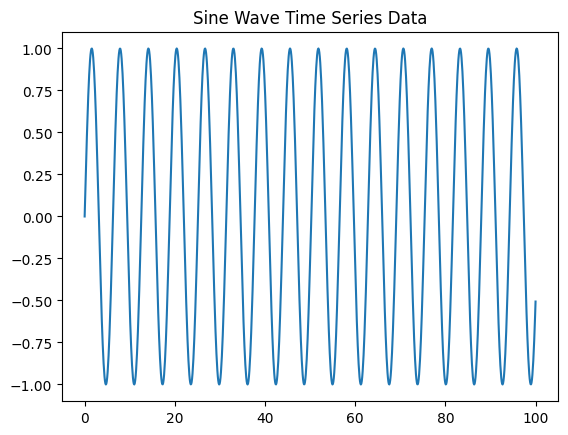

In [ ]:
# Generate synthetic time series data (sine wave)
time_steps = np.linspace(0, 100, 1000)
data = np.sin(time_steps)

# Plot the data
plt.plot(time_steps, data)
plt.title("Sine Wave Time Series Data")
plt.show()


### Seasonality and Trend

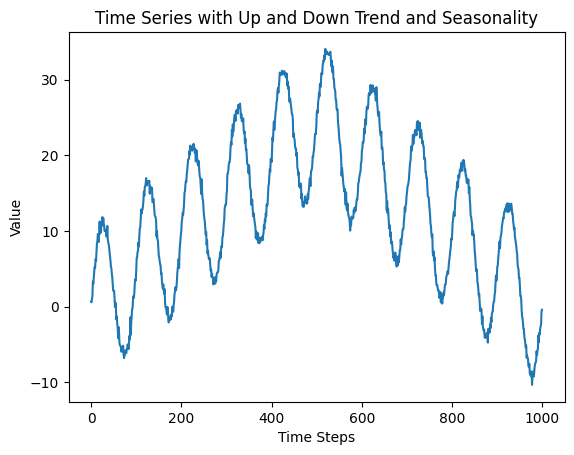

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate time series with seasonality and a unidirectional trend that reverses
def generate_seasonal_up_down_trend_data(n_steps=1000, trend_slope=0.05, seasonality_amplitude=5, seasonality_period=100, noise_factor=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)  # For reproducibility

    # Generate trend: increasing for the first half, decreasing for the second half
    trend = np.zeros(n_steps)
    midpoint = n_steps // 2
    trend[:midpoint] = np.arange(midpoint) * trend_slope  # Upward trend
    trend[midpoint:] = trend_slope * (midpoint - np.arange(midpoint))  # Downward trend

    # Generate seasonality (sine wave pattern)
    time = np.arange(n_steps)
    seasonality = seasonality_amplitude * np.sin(2 * np.pi * time / seasonality_period)

    # Add random noise
    noise = np.random.normal(0, noise_factor, n_steps)

    # Combine trend, seasonality, and noise
    data = trend + seasonality + noise

    return data

# Generate time series data with up and down trend and seasonality
n_steps = 1000
data = generate_seasonal_up_down_trend_data(n_steps=n_steps,
                                             trend_slope=0.05,
                                             seasonality_amplitude=10,
                                             seasonality_period=100,
                                             noise_factor=0.5)

# Plot the generated data
plt.plot(data)
plt.title("Time Series with Up and Down Trend and Seasonality")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()


### Random-walk

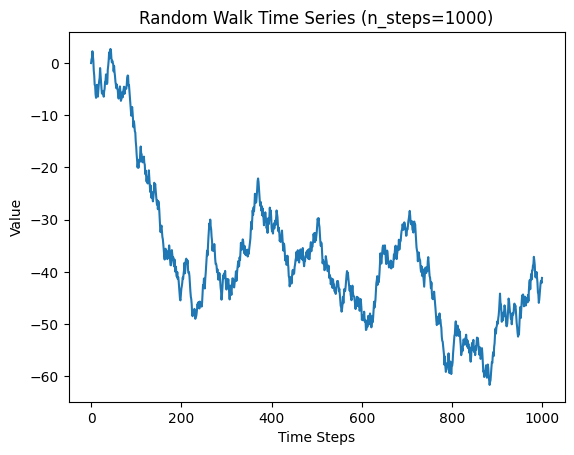

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate random walk
def generate_random_walk(n_steps=1000, noise_factor=0.2, seed=None):
    if seed is not None:
        np.random.seed(seed)  # For reproducibility

    # Initialize random walk with starting value at 0
    steps = [0]

    for i in range(1, n_steps):
        # Generate a random step: -1 or 1, plus some Gaussian noise
        step = steps[-1] + np.random.choice([-1, 1]) + np.random.normal(0, noise_factor)
        steps.append(step)

    return np.array(steps)

# Generate random walk with noise
n_steps = 1000
data = generate_random_walk(n_steps=n_steps, noise_factor=0.5, seed=1)

# Plot the random walk
plt.plot(data)
plt.title(f"Random Walk Time Series (n_steps={n_steps})")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()


In [ ]:
data.shape

(10, 100)

### Preprocessing

In [ ]:
# Rescale data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Create sequences of 50 time steps (lookback window)
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 20 # context length, look-back window
X, y = create_sequences(scaled_data, time_step)

# Convert to PyTorch tensors
X = torch.Tensor(X)  # Correct shape: (num_samples, time_step, input_size)
y = torch.Tensor(y)  # Correct shape: (num_samples,)
X.shape

torch.Size([980, 20, 1])

# Model

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=25, output_size=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # out contains all hidden states
        out = out[:, -1, :]    # Take only the last output
        out = self.fc(out)
        return out

# Initialize the model
model = RNN(hidden_size=4)

#### Weights before training

In [ ]:
weight_ih = model.rnn.weight_ih_l0  # Input-to-hidden weights
weight_hh = model.rnn.weight_hh_l0  # Hidden-to-hidden weights
bias_ih = model.rnn.bias_ih_l0      # Input-to-hidden bias
bias_hh = model.rnn.bias_hh_l0      # Hidden-to-hidden bias
weight_ho = model.fc.weight         # Hidden-to-Output weights
# Print the shapes of the weights and biases
print(f"Weight Input-to-Hidden W: {weight_ih}")
print(f"Weight Hidden-to-Hidden U: {weight_hh}")
print(f"Bias Input-to-Hidden : {bias_ih}")
print(f"Bias Hidden-to-Hidden : {bias_hh}")
print(f"Bias Hidden-to-Output V : {weight_ho}")

Weight Input-to-Hidden W: Parameter containing:
tensor([[ 0.4077],
        [ 0.3773],
        [-0.1109],
        [-0.1806]], requires_grad=True)
Weight Hidden-to-Hidden U: Parameter containing:
tensor([[-0.0727,  0.3294,  0.3293,  0.3615],
        [ 0.2217,  0.3003, -0.1764,  0.0355],
        [ 0.0394, -0.2458, -0.0571, -0.1017],
        [ 0.4825,  0.1104, -0.2174,  0.0759]], requires_grad=True)
Bias Input-to-Hidden : Parameter containing:
tensor([-0.3907,  0.3342,  0.1729,  0.2814], requires_grad=True)
Bias Hidden-to-Hidden : Parameter containing:
tensor([-0.2647,  0.1114,  0.0003, -0.2031], requires_grad=True)
Bias Hidden-to-Output V : Parameter containing:
tensor([[-0.0281, -0.2791,  0.4306, -0.0842]], requires_grad=True)


### Loss function

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [ ]:
# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()

    # Forward pass
    output = model(X)
    loss = criterion(output, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.1232
Epoch [20/100], Loss: 0.1000
Epoch [30/100], Loss: 0.0847
Epoch [40/100], Loss: 0.0768
Epoch [50/100], Loss: 0.0731
Epoch [60/100], Loss: 0.0705
Epoch [70/100], Loss: 0.0682
Epoch [80/100], Loss: 0.0661
Epoch [90/100], Loss: 0.0643
Epoch [100/100], Loss: 0.0627


#### Weights after training

In [ ]:
weight_ih = model.rnn.weight_ih_l0  # Input-to-hidden weights
weight_hh = model.rnn.weight_hh_l0  # Hidden-to-hidden weights
bias_ih = model.rnn.bias_ih_l0      # Input-to-hidden bias
bias_hh = model.rnn.bias_hh_l0      # Hidden-to-hidden bias
weight_ho = model.fc.weight         # Hidden-to-Output weights
# Print the shapes of the weights and biases
print(f"Weight Input-to-Hidden W: {weight_ih}")
print(f"Weight Hidden-to-Hidden U: {weight_hh}")
print(f"Bias Input-to-Hidden : {bias_ih}")
print(f"Bias Hidden-to-Hidden : {bias_hh}")
print(f"Bias Hidden-to-Output V : {weight_ho}")

Weight Input-to-Hidden W: Parameter containing:
tensor([[ 0.3302],
        [ 0.3050],
        [-0.0440],
        [-0.2579]], requires_grad=True)
Weight Hidden-to-Hidden U: Parameter containing:
tensor([[-0.0495,  0.2670,  0.3860,  0.4418],
        [ 0.1807,  0.2509, -0.0826,  0.0487],
        [ 0.0336, -0.1945, -0.1166, -0.1662],
        [ 0.4846,  0.0509, -0.1450,  0.1455]], requires_grad=True)
Bias Input-to-Hidden : Parameter containing:
tensor([-0.4428,  0.3118,  0.2130,  0.2364], requires_grad=True)
Bias Hidden-to-Hidden : Parameter containing:
tensor([-0.3167,  0.0890,  0.0404, -0.2481], requires_grad=True)
Bias Hidden-to-Output V : Parameter containing:
tensor([[-0.0354, -0.2238,  0.3695, -0.1554]], requires_grad=True)


## Evaluation

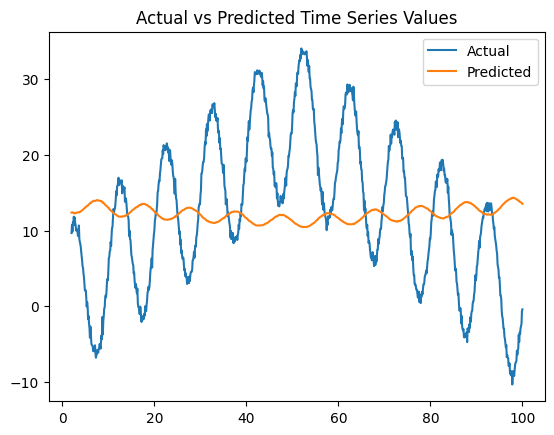

In [ ]:
# Make predictions
model.eval()
predicted = model(X).detach().numpy()

# Inverse transform to original scale
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y.numpy().reshape(-1, 1))

# Plot actual vs predicted values
plt.plot(time_steps[time_step:], actual, label='Actual')
plt.plot(time_steps[time_step:], predicted, label='Predicted')
plt.title("Actual vs Predicted Time Series Values")
plt.legend()
plt.show()


(1, 2000)


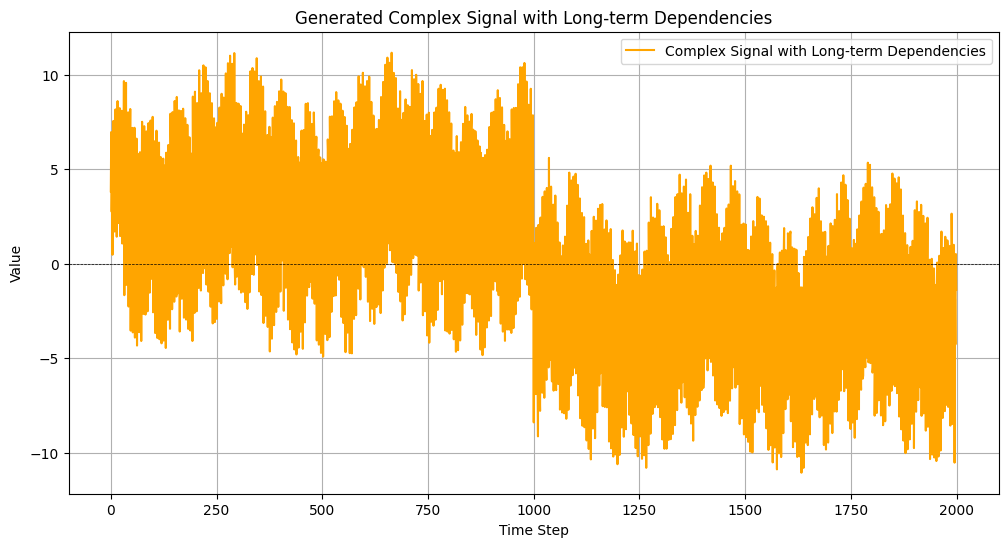

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_complex_signal(n_sequences=10, seq_length=1000, dependency_steps=100, noise_factor=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)

    data = np.zeros((n_sequences, seq_length))

    for i in range(n_sequences):
      # Time variable
      t = np.arange(seq_length)

      # Generate oscillatory patterns
      sine_wave1 = np.sin(.1 * t)  # Low frequency
      sine_wave2 = np.sin(1.3 * t)  # Medium frequency
      sine_wave3 = np.sin(2.5 * t)  # High frequency

      # Create a complex signal by combining the sine waves
      base_signal = sine_wave1*1.82 + sine_wave2 * 2.2 + 2 * sine_wave3

      # Introduce long-term dependencies by shifting the base signal
      long_term_dependency = np.roll(base_signal, dependency_steps)  # Shift by dependency steps
      long_term_dependency[:dependency_steps] = 0  # Avoid wrapping effects at the beginning

      # Create a trend that changes periodically
      trend = np.zeros(seq_length)
      trend[:seq_length//2] = 3  # Positive trend for the first half
      trend[seq_length//2:] = -3  # Negative trend for the second half

      # Combine all components into one complex signal
      data[i] = base_signal + long_term_dependency + trend + noise_factor * np.random.randn(seq_length)

    return data

# Generate the complex signal
data = create_complex_signal(n_sequences=1, seq_length=2000, dependency_steps=30)
print(data.shape)
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data[0], label='Complex Signal with Long-term Dependencies', color='orange')
plt.title('Generated Complex Signal with Long-term Dependencies')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid()
plt.legend()
plt.show()


In [ ]:
data.shape

(1, 1000)

### Prep data

In [ ]:
n_sequences = data.shape[0]

if n_sequences > 5:
  train_size = int(0.4 * n_sequences)   # 70% for training
  val_size = int(0.4 * n_sequences)    # 15% for validation
  test_size = n_sequences - train_size - val_size  # 15% for testing

  # Split the data
  train_data = data[:train_size]
  val_data = data[train_size:train_size + val_size]
  test_data = data[train_size + val_size:]
else:
  train_data = data
  val_data = data
  test_data = data
# Check the shapes of the splits
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (1, 2000)
Validation Data Shape: (1, 2000)
Test Data Shape: (1, 2000)


In [ ]:
def prepare_input_output(data, input_steps, output_steps=1):
    X, y = [], []
    for sequence in data:
        for t in range(len(sequence) - input_steps - output_steps + 1):
            X.append(sequence[t:t + input_steps])  # Input
            y.append(sequence[t + input_steps:t + input_steps + output_steps])  # Output
    return np.array(X), np.array(y)

# Define the number of input time steps
input_steps = 20  # last N time steps to predict the next value

# Prepare training, validation, and test sets
X_train, y_train = prepare_input_output(train_data, input_steps)
X_val, y_val = prepare_input_output(val_data, input_steps)
X_test, y_test = prepare_input_output(test_data, input_steps)

# Check the shapes of the prepared input-output pairs
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

# Rescale data to [0, 1]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Rescale and reshape the data for RNN
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)

X_val_scaled = scaler_X.transform(X_val.reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1], 1)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)

X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
# Create tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Create a DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=500, shuffle=True)

# Check the shapes of the prepared input-output pairs
print(f"X_train_tensor Shape: {X_train_tensor.shape}, y_train Shape: {y_train.shape}")
print(f"X_val_tensor Shape: {X_val_tensor.shape}, y_val Shape: {y_val.shape}")
print(f"X_test_tensor Shape: {X_test_tensor.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (1980, 20), y_train Shape: (1980, 1)
X_val Shape: (1980, 20), y_val Shape: (1980, 1)
X_test Shape: (1980, 20), y_test Shape: (1980, 1)
X_train_tensor Shape: torch.Size([1980, 20, 1]), y_train Shape: (1980, 1)
X_val_tensor Shape: torch.Size([1980, 20, 1]), y_val Shape: (1980, 1)
X_test_tensor Shape: torch.Size([1980, 20, 1]), y_test Shape: (1980, 1)


## Fit model

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=25, output_size=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # out contains all hidden states
        out = out[:, -1, :]    # Take only the last output
        out = self.fc(out)
        return out

# Initialize the model
model = RNN(hidden_size=2)

In [ ]:
weight_ih = model.rnn.weight_ih_l0  # Input-to-hidden weights
weight_hh = model.rnn.weight_hh_l0  # Hidden-to-hidden weights
bias_ih = model.rnn.bias_ih_l0      # Input-to-hidden bias
bias_hh = model.rnn.bias_hh_l0      # Hidden-to-hidden bias
weight_ho = model.fc.weight         # Hidden-to-Output weights

# Print the shapes of the weights and biases
print(f"Weight Input-to-Hidden W: {weight_ih}")
print(f"Weight Hidden-to-Hidden U: {weight_hh}")
print(f"Bias Input-to-Hidden : {bias_ih}")
print(f"Bias Hidden-to-Hidden : {bias_hh}")
print(f"Bias Hidden-to-Output V : {weight_ho}")

Weight Input-to-Hidden W: Parameter containing:
tensor([[-0.0875],
        [-0.4279],
        [ 0.4090],
        [-0.3297],
        [-0.2954]], requires_grad=True)
Weight Hidden-to-Hidden U: Parameter containing:
tensor([[ 0.3262, -0.0642,  0.1788,  0.3843, -0.3297],
        [-0.0734,  0.2433,  0.3214,  0.2260,  0.3185],
        [ 0.2656,  0.2273, -0.1536, -0.1825, -0.4210],
        [-0.2560, -0.2398,  0.2330, -0.3159, -0.2893],
        [ 0.4159,  0.3210, -0.1583, -0.3646,  0.1450]], requires_grad=True)
Bias Input-to-Hidden : Parameter containing:
tensor([ 0.1364,  0.3119,  0.3551,  0.0334, -0.4384], requires_grad=True)
Bias Hidden-to-Hidden : Parameter containing:
tensor([-0.2525, -0.3963, -0.3025,  0.0634, -0.0677], requires_grad=True)
Bias Hidden-to-Output V : Parameter containing:
tensor([[ 0.0262,  0.0111, -0.0655,  0.1883,  0.1084]], requires_grad=True)


### Training loop

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
gradients = []

# Training loop
for epoch in range(500):  # Example epoch count
    for batch_data, batch_targets in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_data)  # Forward pass
        loss = criterion(outputs, batch_targets)  # Compute loss
        loss.backward()  # Backward pass

        # Store gradients for analysis
        grad_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2  # L2 norm of gradients
        gradients.append(np.sqrt(grad_norm))  # Append the norm to the list

        optimizer.step()  # Update weights
    if (epoch + 1) % 50 == 0:
      print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.8f}')

Epoch [50/10], Loss: 0.04959499
Epoch [100/10], Loss: 0.04660592
Epoch [150/10], Loss: 0.04479795
Epoch [200/10], Loss: 0.05311877
Epoch [250/10], Loss: 0.04637661
Epoch [300/10], Loss: 0.04779124
Epoch [350/10], Loss: 0.04910695
Epoch [400/10], Loss: 0.04470779
Epoch [450/10], Loss: 0.03851711
Epoch [500/10], Loss: 0.04511915


### Visualize gradient decay

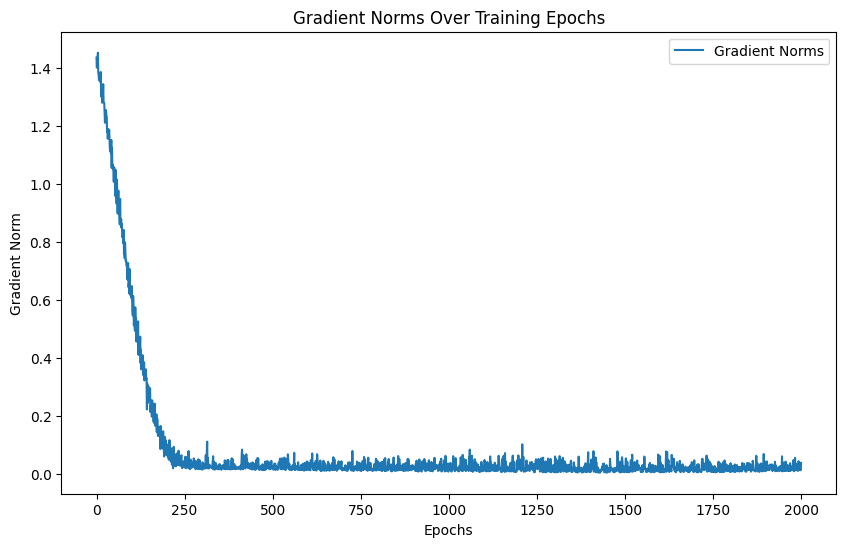

In [ ]:
# Plotting the gradient norms
plt.figure(figsize=(10, 6))
plt.plot(gradients, label='Gradient Norms')
plt.title('Gradient Norms Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

#### Weights after training

In [ ]:
weight_ih = model.rnn.weight_ih_l0  # Input-to-hidden weights
weight_hh = model.rnn.weight_hh_l0  # Hidden-to-hidden weights
bias_ih = model.rnn.bias_ih_l0      # Input-to-hidden bias
bias_hh = model.rnn.bias_hh_l0      # Hidden-to-hidden bias
weight_ho = model.fc.weight         # Hidden-to-Output weights
# Print the shapes of the weights and biases
print(f"Weight Input-to-Hidden W: {weight_ih}")
print(f"Weight Hidden-to-Hidden U: {weight_hh}")
print(f"Bias Input-to-Hidden : {bias_ih}")
print(f"Bias Hidden-to-Hidden : {bias_hh}")
print(f"Bias Hidden-to-Output V : {weight_ho}")

Weight Input-to-Hidden W: Parameter containing:
tensor([[0.1382],
        [0.5066]], requires_grad=True)
Weight Hidden-to-Hidden U: Parameter containing:
tensor([[ 0.0912, -0.5277],
        [ 0.7117,  0.5592]], requires_grad=True)
Bias Input-to-Hidden : Parameter containing:
tensor([-0.5088,  0.3559], requires_grad=True)
Bias Hidden-to-Hidden : Parameter containing:
tensor([-0.1424,  0.1768], requires_grad=True)
Bias Hidden-to-Output V : Parameter containing:
tensor([[-0.5076,  0.1750]], requires_grad=True)


## Eval

RMSE: 9.271994398207658


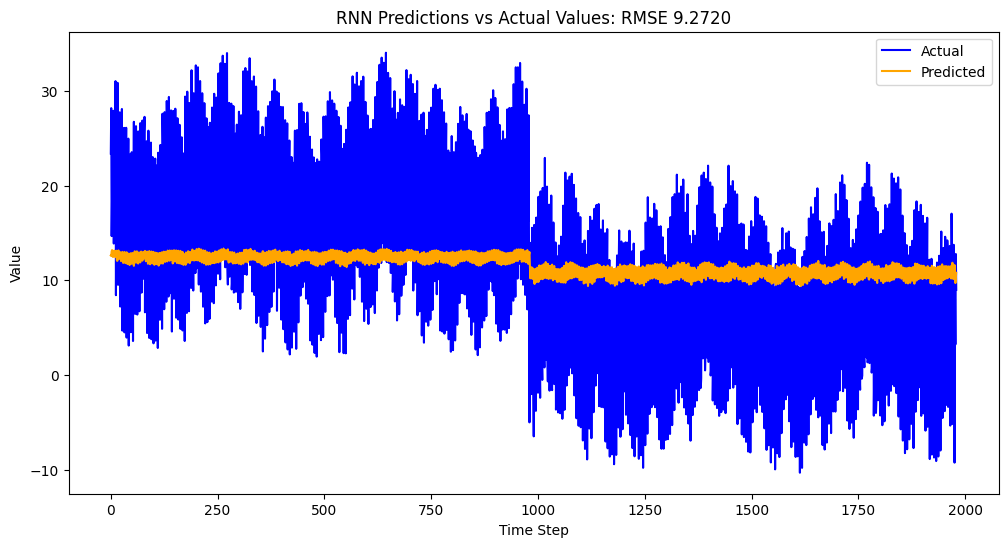

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_train_tensor)

y_hat = scaler.inverse_transform(predictions.numpy())
y = scaler.inverse_transform(y_train_tensor.reshape(-1, 1))

rmse = np.sqrt(np.mean((y - y_hat) ** 2))
print(f'RMSE: {rmse}')

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual', color='blue')  # Actual values
plt.plot(y_hat, label='Predicted', color='orange')  # Predicted values
plt.title(f'RNN Predictions vs Actual Values: RMSE {rmse:.4f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# LSTM

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=25, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)  # Change to LSTM
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # out contains all hidden states
        out = out[:, -1, :]    # Take only the last output
        out = self.fc(out)
        return out

def print_lstm_weights(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:  # Check if the parameter belongs to LSTM
            print(f"Parameter name: {name}")
            print(param.data)  # Print the weight matrix
            print()

In [ ]:
# Initialize the model
model = LSTMModel(input_size=1, hidden_size=15, output_size=1)
print_lstm_weights(model)

### Training

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
gradients = []
for epoch in range(500):  # Example epoch count
    for batch_data, batch_targets in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_data)  # Forward pass
        loss = criterion(outputs, batch_targets)  # Compute loss
        loss.backward()  # Backward pass

        # Store gradients for analysis
        grad_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2  # L2 norm of gradients
        gradients.append(np.sqrt(grad_norm))  # Append the norm to the list

        optimizer.step()  # Update weights
    if (epoch + 1) % 50 == 0:
      print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.8f}')

Epoch [50/10], Loss: 0.04004197
Epoch [100/10], Loss: 0.02938467
Epoch [150/10], Loss: 0.02509273
Epoch [200/10], Loss: 0.02582619
Epoch [250/10], Loss: 0.01887583
Epoch [300/10], Loss: 0.01355834
Epoch [350/10], Loss: 0.01036383
Epoch [400/10], Loss: 0.00919377
Epoch [450/10], Loss: 0.00834309
Epoch [500/10], Loss: 0.00739006


### Visualize Gradient decay/explosion

- Keep the hidden layer size very low

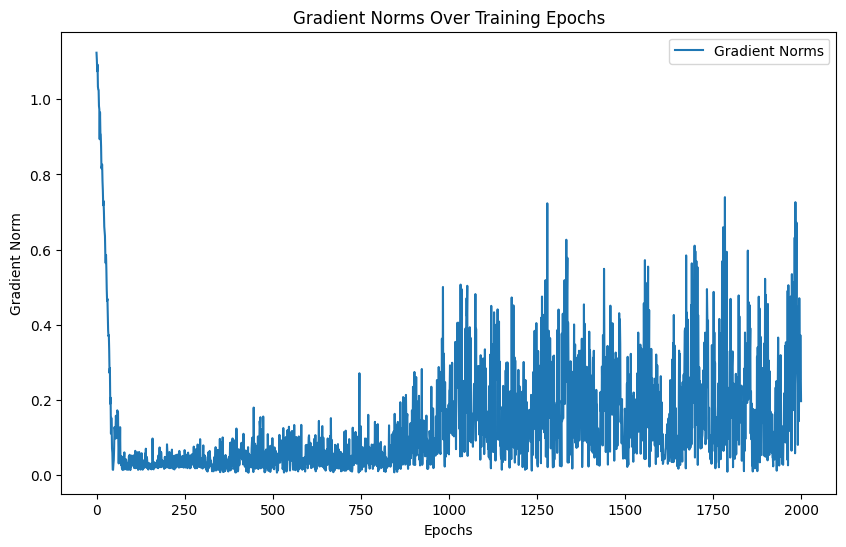

In [ ]:
# Plotting the gradient norms
plt.figure(figsize=(10, 6))
plt.plot(gradients, label='Gradient Norms')
plt.title('Gradient Norms Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

## Eval

RMSE: 4.20832602027253


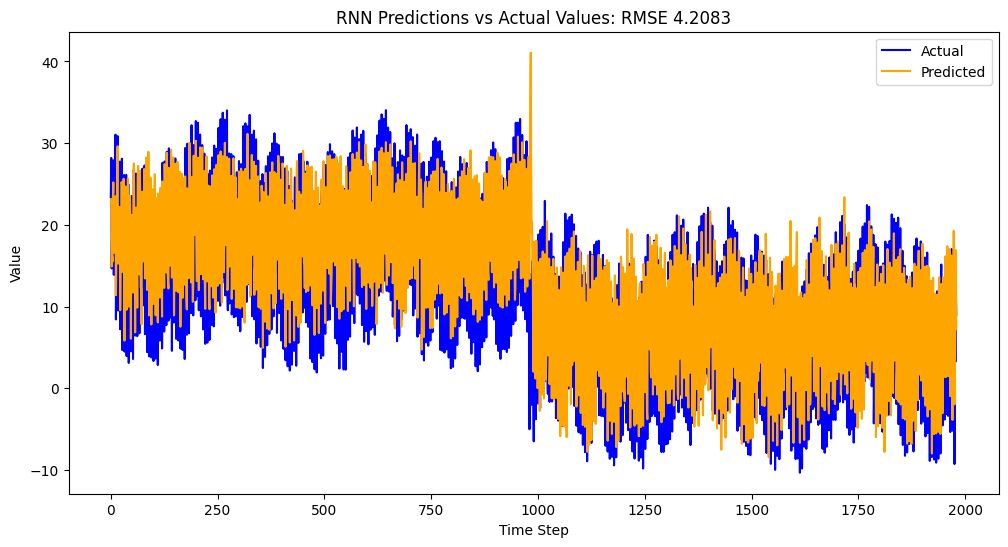

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_train_tensor)

y_hat = scaler.inverse_transform(predictions.numpy())
y = scaler.inverse_transform(y_train_tensor.reshape(-1, 1))

rmse = np.sqrt(np.mean((y - y_hat) ** 2))
print(f'RMSE: {rmse}')

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual', color='blue')  # Actual values
plt.plot(y_hat, label='Predicted', color='orange')  # Predicted values
plt.title(f'RNN Predictions vs Actual Values: RMSE {rmse:.4f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


**Lab Exercises:**

  -  Experiment with Hidden Sizes: Try changing the hidden layer size and observe how it affects the model performance.
  -  Use Real-World Data: Apply the RNN model to a real-world dataset (e.g., stock prices or weather data).
  -  Add More Layers: Try building a deeper RNN model by stacking multiple RNN layers and see how it affects the predictions.